<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
결론적으로 LSTM은 seasonal에 주고 trend와 seasonal의 비율을 적당히 맞추는게 중요함<br>
&rightarrow; 이번에는 scaling 없이

+ Sample3에 대해서

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [5]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [6]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        self.Linear_Sum = nn.Linear(2,1)
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        SUM_OUTPUT = self.Linear_Sum(torch.cat([season_output,trend_output],dim=2))
        output = SUM_OUTPUT
        
        return output,season_output,trend_output

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_537691/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [14]:
target

tensor([[[0.2092]],

        [[0.2202]],

        [[0.2011]],

        ...,

        [[0.1768]],

        [[0.1615]],

        [[0.1736]]], device='cuda:0')

In [15]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),6*1e-7)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 6.0000e-07.


In [16]:
torch.manual_seed(42)

In [17]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [18]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#        print(out)
        loss = criterion(out,tg)
    
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 5.7000e-07.
smape 14.875894511303706 %
Adjusting learning rate of group 0 to 5.4150e-07.
smape 14.819029469849074 %
Adjusting learning rate of group 0 to 5.1442e-07.
smape 14.80679695412778 %
Adjusting learning rate of group 0 to 4.8870e-07.
smape 14.799827230516929 %
Adjusting learning rate of group 0 to 4.6427e-07.
smape 14.790973406698967 %
Adjusting learning rate of group 0 to 4.4106e-07.
smape 14.782196654562366 %
Adjusting learning rate of group 0 to 4.1900e-07.
smape 14.773422606855805 %
Adjusting learning rate of group 0 to 3.9805e-07.
smape 14.76531922076529 %
Adjusting learning rate of group 0 to 3.7815e-07.
smape 14.757284264989764 %
Adjusting learning rate of group 0 to 3.5924e-07.
smape 14.74989847263746 %
Adjusting learning rate of group 0 to 3.4128e-07.
smape 14.742999232826175 %
Adjusting learning rate of group 0 to 3.2422e-07.
smape 14.735636722013268 %
Adjusting learning rate of group 0 to 3.0801e-07.
smape 14.728819978428865 %
Ad

In [19]:
print(ss_list[26])
print(tr_list[0])

tensor([[[-0.1549]],

        [[-0.1548]],

        [[-0.1547]],

        [[-0.1545]],

        [[-0.1545]],

        [[-0.1547]],

        [[-0.1552]],

        [[-0.1551]],

        [[-0.1547]],

        [[-0.1548]],

        [[-0.1553]],

        [[-0.1555]],

        [[-0.1555]],

        [[-0.1552]],

        [[-0.1549]],

        [[-0.1550]],

        [[-0.1553]],

        [[-0.1550]],

        [[-0.1546]],

        [[-0.1545]],

        [[-0.1548]],

        [[-0.1546]],

        [[-0.1546]],

        [[-0.1544]],

        [[-0.1545]],

        [[-0.1547]],

        [[-0.1551]],

        [[-0.1549]],

        [[-0.1546]],

        [[-0.1546]],

        [[-0.1548]],

        [[-0.1549]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[0.0831]],

        [[0.0829]],

        [[0.0824]],

        [[0.0816]],

        [[0.0810]],

        [[0.0800]],

        [[0.0812]],

        [[0.0820]],

        [[0.0811]],

        [[0.0805]],

        [[0.0811]],

        [[0.0811]],

  

In [20]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.679174670483917 %
SMAPE 21.133996829390526 %
SMAPE 10.294749394059181 %
SMAPE 3.5586592294275765 %
SMAPE 5.886152293533087 %
SMAPE 7.33099077641964 %
SMAPE 2.7877101618796587 %
SMAPE 3.6228105165064335 %
SMAPE 4.023143697530031 %
SMAPE 0.8014044295996426 %
SMAPE 0.960229592397809 %
SMAPE 16.151800349354744 %
SMAPE 4.851896554231644 %
SMAPE 2.152569340541959 %
SMAPE 10.279411382973194 %
SMAPE 0.9221599707379936 %
SMAPE 12.324489116668701 %
SMAPE 13.794108256697655 %
SMAPE 9.714518256485462 %
SMAPE 8.128490574657917 %
SMAPE 14.758041873574257 %
SMAPE 5.82365170493722 %
SMAPE 9.350180245935917 %
SMAPE 12.726409628987312 %
SMAPE 10.122715875506401 %
SMAPE 1.8259262833744287 %
SMAPE 17.663881316781044 %
SMAPE 11.916224218904972 %
SMAPE 12.980488508939745 %
SMAPE 16.973337918519974 %
SMAPE 17.696387737989426 %
SMAPE 5.321708109229803 %
SMAPE 8.423739396035671 %
SMAPE 10.182444155216217 %
SMAPE 6.908574618399143 %
SMAPE 2.438498290255666 %
SMAPE 17.638228327035904 %
SMAPE 13.991401821

SMAPE 15.546950235962868 %
SMAPE 0.7181950840167701 %
SMAPE 8.015110686421394 %
SMAPE 6.252874802798032 %
SMAPE 23.483567520976067 %
SMAPE 8.887366905808449 %
SMAPE 23.72138223052025 %
SMAPE 12.120784342288971 %
SMAPE 11.578030973672867 %
SMAPE 15.972865775227547 %
SMAPE 17.279248639941216 %
SMAPE 0.8187122019007802 %
SMAPE 7.21559177339077 %
SMAPE 11.887307040393353 %
SMAPE 4.534560345113277 %
SMAPE 4.404678247869015 %
SMAPE 19.07240031659603 %
SMAPE 9.159374982118607 %
SMAPE 19.123087167739868 %
SMAPE 20.062591403722763 %
SMAPE 17.994581773877144 %
SMAPE 10.48324365913868 %
SMAPE 0.4755979822948575 %
SMAPE 7.583481311798096 %
SMAPE 3.3922471702098846 %
SMAPE 3.8679890185594563 %
SMAPE 15.318949088454248 %
SMAPE 9.076392099261284 %
SMAPE 10.716293223202229 %
SMAPE 14.330379515886307 %
SMAPE 13.634406805038452 %
SMAPE 4.758958533406258 %
SMAPE 5.926535505801439 %
SMAPE 4.833912920206785 %
SMAPE 15.102936491370201 %
SMAPE 5.447986837476492 %
SMAPE 22.234547778964043 %
SMAPE 22.349387258

SMAPE 6.966111414134503 %
SMAPE 0.5314571070484817 %
SMAPE 6.1772023886442184 %
SMAPE 4.903311997652054 %
SMAPE 12.97538858652115 %
SMAPE 6.655908279120921 %
SMAPE 2.697966005653143 %
SMAPE 3.215664282441139 %
SMAPE 0.12301180372014642 %
SMAPE 6.072562221437693 %
SMAPE 17.94695784151554 %
SMAPE 11.97228629887104 %
SMAPE 3.649142742156983 %
SMAPE 2.834975128993392 %
SMAPE 16.611665666103363 %
SMAPE 3.011812997981906 %
SMAPE 0.6464576148428023 %
SMAPE 3.743459355086088 %
SMAPE 3.5388096943497658 %
SMAPE 5.152797602117062 %
SMAPE 7.197458401322365 %
SMAPE 5.728325042873621 %
SMAPE 2.054140266031027 %
SMAPE 3.2361476346850395 %
SMAPE 12.533881321549414 %
SMAPE 9.158066518604755 %
SMAPE 2.4669109489768744 %
SMAPE 1.5591041212901473 %
SMAPE 5.552043844014406 %
SMAPE 5.288794934749603 %
SMAPE 8.344757109880447 %
SMAPE 9.848098427057266 %
SMAPE 3.97901863604784 %
SMAPE 8.98462375998497 %
SMAPE 7.439174845814706 %
SMAPE 11.527095161378384 %
SMAPE 8.635979413986206 %
SMAPE 0.6856112168170512 %
S

SMAPE 2.7920423317700624 %
SMAPE 9.870537772774696 %
SMAPE 8.420041881501675 %
SMAPE 12.726028054952621 %
SMAPE 1.5379134835675359 %
SMAPE 7.4690093845129 %
SMAPE 9.42051949352026 %
SMAPE 9.680193223059177 %
SMAPE 2.0239812284708023 %
SMAPE 4.398838460445404 %
SMAPE 2.1089677028357983 %
SMAPE 6.554639130830766 %
SMAPE 4.760085489600897 %
SMAPE 9.411783620715141 %
SMAPE 8.231186851859093 %
SMAPE 8.540017753839493 %
SMAPE 12.971516594290733 %
SMAPE 12.914810389280317 %
SMAPE 3.600793037563563 %
SMAPE 0.7517796284519136 %
SMAPE 1.6233925763517616 %
SMAPE 6.7585998475551605 %
SMAPE 8.995411165058613 %
SMAPE 10.226347789168358 %
SMAPE 1.467052560299635 %
SMAPE 1.2164750332012773 %
SMAPE 9.392281889915466 %
SMAPE 8.86124525219202 %
SMAPE 16.13662016391754 %
SMAPE 10.60733150690794 %
SMAPE 4.494262635707855 %
SMAPE 0.6321198912337422 %
SMAPE 10.944484166800976 %
SMAPE 11.252880118787289 %
SMAPE 8.399069793522358 %
SMAPE 0.706974730361253 %
SMAPE 8.417097829282284 %
SMAPE 7.292086333036423 %
S

SMAPE 0.3873996266629547 %
SMAPE 4.742979649454355 %
SMAPE 15.262378811836241 %
SMAPE 8.858852043747902 %
SMAPE 1.1519447965547442 %
SMAPE 0.47851778985932464 %
SMAPE 1.7150887623429298 %
SMAPE 6.114283546805382 %
SMAPE 8.416126921772957 %
SMAPE 3.048886276781559 %
SMAPE 0.12493881315458566 %
SMAPE 2.473859580233693 %
SMAPE 11.327585577964783 %
SMAPE 6.4555514827370635 %
SMAPE 0.5521454126574099 %
SMAPE 3.5091037377715106 %
SMAPE 2.5894092712551355 %
SMAPE 5.497728068381548 %
SMAPE 27.207842707633972 %
SMAPE 19.146502062678337 %
SMAPE 14.455794155597687 %
SMAPE 9.021983943879604 %
SMAPE 24.30308711528778 %
SMAPE 3.811771217733621 %
SMAPE 9.987098313868046 %
SMAPE 12.847275823354721 %
SMAPE 10.335002027451992 %
SMAPE 11.704151637852192 %
SMAPE 21.034237042069435 %
SMAPE 12.455015286803246 %
SMAPE 7.6685220673680305 %
SMAPE 7.220670223236084 %
SMAPE 18.580133348703384 %
SMAPE 2.950887594372034 %
SMAPE 6.850714161992073 %
SMAPE 4.229387599974871 %
SMAPE 0.7685761731117964 %
SMAPE 4.268620

SMAPE 3.7092460766434665 %
SMAPE 7.314865492284298 %
SMAPE 7.650483973324299 %
SMAPE 7.4832842499017715 %
SMAPE 7.492694787681104 %
SMAPE 7.516980849206448 %
SMAPE 8.749590121209621 %
SMAPE 7.387236058712006 %
SMAPE 21.16058124601841 %
SMAPE 10.777923613786697 %
SMAPE 0.8838033340871333 %
SMAPE 6.625856682658196 %
SMAPE 3.9341731518507004 %
SMAPE 14.656000182032585 %
SMAPE 6.5636998414993295 %
SMAPE 7.492606744170188 %
SMAPE 6.8781459257006645 %
SMAPE 7.067081101238728 %
SMAPE 8.42727342993021 %
SMAPE 3.9257279820740223 %
SMAPE 0.8197709219530225 %
SMAPE 15.558362409472466 %
SMAPE 0.755953926127404 %
SMAPE 20.457360669970512 %
SMAPE 15.233312353491781 %
SMAPE 8.712973937392235 %
SMAPE 11.148886233568192 %
SMAPE 9.375861071050167 %
SMAPE 4.05736530572176 %
SMAPE 3.485384438186884 %
SMAPE 11.4472381696105 %
SMAPE 18.486518040299416 %
SMAPE 0.21125877299346033 %
SMAPE 22.72115622460842 %
SMAPE 15.921933993697165 %
SMAPE 11.326866775751114 %
SMAPE 16.38167129456997 %
SMAPE 14.1696866452693

SMAPE 7.060350872576236 %
SMAPE 8.527634553611279 %
SMAPE 4.223534666001797 %
SMAPE 10.906036332249641 %
SMAPE 0.10026179137639703 %
SMAPE 5.18898268789053 %
SMAPE 8.95516188442707 %
SMAPE 10.392304696142673 %
SMAPE 10.670764736831188 %
SMAPE 6.361467771232128 %
SMAPE 1.3711421564221382 %
SMAPE 13.049546569585802 %
SMAPE 3.268737424165011 %
SMAPE 7.360166914761066 %
SMAPE 8.055363096296787 %
SMAPE 2.9073388502001762 %
SMAPE 5.991254109889269 %
SMAPE 8.811035588383675 %
SMAPE 8.517120450735092 %
SMAPE 7.610028065741062 %
SMAPE 1.5416626827791333 %
SMAPE 1.9445249326527119 %
SMAPE 2.814215874299407 %
SMAPE 9.321933723986149 %
SMAPE 6.683217890560628 %
SMAPE 3.666217662394047 %
SMAPE 10.728920213878155 %
SMAPE 15.807410642504694 %
SMAPE 12.763225317001343 %
SMAPE 2.0000875014811754 %
SMAPE 9.31769036501646 %
SMAPE 13.232144653797151 %
SMAPE 0.7781807035207748 %
SMAPE 11.179339900612831 %
SMAPE 7.659911476075649 %
SMAPE 3.2011368125677104 %
SMAPE 14.854215204715729 %
SMAPE 14.2546800374984

SMAPE 6.390722043812275 %
SMAPE 6.617258429527283 %
SMAPE 3.2374360710382457 %
SMAPE 2.472358424216509 %
SMAPE 3.844050984829664 %
SMAPE 12.19093719869852 %
SMAPE 9.523242093622684 %
SMAPE 7.633880592882633 %
SMAPE 0.1211214807117358 %
SMAPE 5.122827675193548 %
SMAPE 4.528700936585665 %
SMAPE 3.789086017757654 %
SMAPE 9.716230377554893 %
SMAPE 0.8530365843325853 %
SMAPE 3.464217189699412 %
SMAPE 5.3131043165922165 %
SMAPE 6.5230962708592415 %
SMAPE 16.85975679755211 %
SMAPE 6.269782163202763 %
SMAPE 0.48558449605479836 %
SMAPE 2.604064142331481 %
SMAPE 10.443570032715797 %
SMAPE 0.8863979941233993 %
SMAPE 0.6156088737770915 %
SMAPE 2.1596851497888565 %
SMAPE 2.908369766548276 %
SMAPE 8.138588696718216 %
SMAPE 9.392889201641083 %
SMAPE 6.1133407056331635 %
SMAPE 3.1790649406611924 %
SMAPE 1.299499743618071 %
SMAPE 6.440173111855983 %
SMAPE 10.608544185757637 %
SMAPE 6.201461177319288 %
SMAPE 0.8275470519438386 %
SMAPE 3.0900668054819107 %
SMAPE 7.359659239649773 %
SMAPE 12.1324373558163

SMAPE 4.1475361585617065 %
SMAPE 1.7709279842674734 %
SMAPE 1.2891563856974244 %
SMAPE 2.097281688824296 %
SMAPE 2.2956282012164593 %
SMAPE 3.478885926306248 %
SMAPE 17.075527250766754 %
SMAPE 4.210211634635925 %
SMAPE 1.5390432849526405 %
SMAPE 6.635088890790939 %
SMAPE 5.790506325662136 %
SMAPE 2.154595574364066 %
SMAPE 0.974603117443621 %
SMAPE 0.18928845378104597 %
SMAPE 1.646032735705376 %
SMAPE 7.910293892025948 %
SMAPE 4.080318216234446 %
SMAPE 0.33239607512950897 %
SMAPE 0.8377504581585528 %
SMAPE 8.171460665762424 %
SMAPE 6.195389226078987 %
SMAPE 1.1820027828216553 %
SMAPE 1.919536804780364 %
SMAPE 0.7442098367027938 %
SMAPE 4.160004239529371 %
SMAPE 4.767872229218483 %
SMAPE 4.726688619703054 %
SMAPE 1.2103458102792501 %
SMAPE 5.13041552528739 %
SMAPE 10.760690681636333 %
SMAPE 4.3270154893398285 %
SMAPE 1.9063662756234407 %
SMAPE 5.059077154844999 %
SMAPE 0.4617356322705745 %
SMAPE 7.1814708933234215 %
SMAPE 7.61208501458168 %
SMAPE 23.182512000203133 %
SMAPE 10.94961289316

SMAPE 12.803406864404678 %
SMAPE 8.394319958984852 %
SMAPE 9.413505464792252 %
SMAPE 4.75272448733449 %
SMAPE 3.614925440400839 %
SMAPE 0.8211247297003865 %
SMAPE 15.910254567861557 %
SMAPE 15.098750576376915 %
SMAPE 9.246808409690857 %
SMAPE 0.29188299318775535 %
SMAPE 13.39217808842659 %
SMAPE 5.215661786496639 %
SMAPE 7.87737101316452 %
SMAPE 4.958658944815397 %
SMAPE 0.896911303512752 %
SMAPE 0.8641787255182862 %
SMAPE 14.681584790349007 %
SMAPE 12.324961245059967 %
SMAPE 11.035105660557747 %
SMAPE 11.415723755955696 %
SMAPE 10.563677802681923 %
SMAPE 5.588920623064041 %
SMAPE 9.612771481275558 %
SMAPE 12.794864118099214 %
SMAPE 9.953775592148304 %
SMAPE 2.65250838175416 %
SMAPE 32.23215654492378 %
SMAPE 24.143402591347694 %
SMAPE 18.951185166835785 %
SMAPE 8.627045825123787 %
SMAPE 12.418037243187428 %
SMAPE 6.851414695382118 %
SMAPE 8.009018801152706 %
SMAPE 9.455416724085808 %
SMAPE 7.016448765993117 %
SMAPE 5.223588023334742 %
SMAPE 19.22876714169979 %
SMAPE 17.641015633940697 

SMAPE 8.716251268982887 %
SMAPE 13.409700632095337 %
SMAPE 8.861231304705143 %
SMAPE 12.40223378688097 %
SMAPE 11.777684472501278 %
SMAPE 17.053978443145752 %
SMAPE 0.49259967310354114 %
SMAPE 3.8166280575096607 %
SMAPE 11.359279252588749 %
SMAPE 3.6510332040488724 %
SMAPE 23.687059730291367 %
SMAPE 0.08081980713177472 %
SMAPE 13.525719642639162 %
SMAPE 14.081532925367354 %
SMAPE 16.550806552171707 %
SMAPE 20.69651684165001 %
SMAPE 5.772822228777841e-05 %
SMAPE 0.9434265671297909 %
SMAPE 7.090097591280937 %
SMAPE 0.6033108071424067 %
SMAPE 14.198051810264586 %
SMAPE 18.771580830216408 %
SMAPE 19.205611273646355 %
SMAPE 16.300618156790733 %
SMAPE 18.900499567389488 %
SMAPE 22.947255447506905 %
SMAPE 6.457192569971085 %
SMAPE 9.940458238124847 %
SMAPE 18.503674551844597 %
SMAPE 7.637379020452499 %
SMAPE 13.62594698369503 %
SMAPE 20.623606950044632 %
SMAPE 21.574004411697388 %
SMAPE 18.32000170648098 %
SMAPE 22.985207304358482 %
SMAPE 18.083296731114388 %
SMAPE 2.115160536020994 %
SMAPE 3

SMAPE 3.222545452415943 %
SMAPE 1.7873256653547287 %
SMAPE 4.387018170207739 %
SMAPE 0.9071411108598113 %
SMAPE 1.2944579096511006 %
SMAPE 5.796488657593727 %
SMAPE 9.06570852547884 %
SMAPE 22.457120314240456 %
SMAPE 16.303492590785027 %
SMAPE 5.444315128028393 %
SMAPE 2.4184834100306034 %
SMAPE 1.322546573355794 %
SMAPE 5.972887367010117 %
SMAPE 8.313439838588238 %
SMAPE 5.082249473780394 %
SMAPE 8.026587069034576 %
SMAPE 11.942878626286983 %
SMAPE 9.81184784322977 %
SMAPE 10.592510879039764 %
SMAPE 4.459050286561251 %
SMAPE 7.143267534673214 %
SMAPE 2.070984283462167 %
SMAPE 4.39634957164526 %
SMAPE 7.771193601191044 %
SMAPE 4.599269699305296 %
SMAPE 10.32759127765894 %
SMAPE 10.349027372896671 %
SMAPE 5.776984427124262 %
SMAPE 7.468798980116845 %
SMAPE 2.5560873225331306 %
SMAPE 2.1077884063124657 %
SMAPE 3.121955158188939 %
SMAPE 2.422777410596609 %
SMAPE 2.004330262541771 %
SMAPE 5.700399521738291 %
SMAPE 5.431705974042416 %
SMAPE 10.255164183676243 %
SMAPE 11.84300945699215 %
SMA

SMAPE 0.344087946228683 %
SMAPE 2.0809951294213533 %
SMAPE 7.00849688053131 %
SMAPE 8.05042178928852 %
SMAPE 0.4005151544697582 %
SMAPE 5.257339391857386 %
SMAPE 8.255326814949512 %
SMAPE 5.2714028134942055 %
SMAPE 0.09586869849590585 %
SMAPE 6.050882559269667 %
SMAPE 1.6737796533852816 %
SMAPE 1.0011742236092687 %
SMAPE 6.221650548279285 %
SMAPE 7.650091618299484 %
SMAPE 6.388209067285061 %
SMAPE 3.5631553903222084 %
SMAPE 0.010024486280599376 %
SMAPE 11.66369840502739 %
SMAPE 3.210675001144409 %
SMAPE 6.0391825176775455 %
SMAPE 1.496562883257866 %
SMAPE 0.3754644119180739 %
SMAPE 2.1557034011930227 %
SMAPE 0.5575221674516797 %
SMAPE 5.218502048403025 %
SMAPE 7.444134898483753 %
SMAPE 11.986011385917664 %
SMAPE 6.708287209272385 %
SMAPE 3.8383396938443184 %
SMAPE 3.259420230984688 %
SMAPE 4.347436733543873 %
SMAPE 2.1813755761832 %
SMAPE 0.8660230180248618 %
SMAPE 2.683802565559745 %
SMAPE 2.2964626885950565 %
SMAPE 5.1123900562524796 %
SMAPE 10.930121056735516 %
SMAPE 7.9956899657845

SMAPE 7.838311314582825 %
SMAPE 9.911243990063667 %
SMAPE 8.322867520153522 %
SMAPE 4.851998459547758 %
SMAPE 10.297791756689548 %
SMAPE 7.7726867869496346 %
SMAPE 17.133027091622353 %
SMAPE 15.801750376820564 %
SMAPE 11.14362844824791 %
SMAPE 7.4601564556360245 %
SMAPE 12.957799702882767 %
SMAPE 17.603594467043877 %
SMAPE 8.64003650099039 %
SMAPE 7.903628095984459 %
SMAPE 5.009712792932987 %
SMAPE 3.1594889536499977 %
SMAPE 24.86307443678379 %
SMAPE 15.618896216154099 %
SMAPE 11.877348348498344 %
SMAPE 3.5718124173581596 %
SMAPE 12.593661159276962 %
SMAPE 12.704727098345755 %
SMAPE 7.999361000955105 %
SMAPE 6.150170233100653 %
SMAPE 7.3194331005215645 %
SMAPE 6.941757321357728 %
SMAPE 13.522331699728966 %
SMAPE 9.568816483020782 %
SMAPE 8.327167473733425 %
SMAPE 4.629907514899969 %
SMAPE 5.578285273164511 %
SMAPE 11.37006912380457 %
SMAPE 0.8810001891106367 %
SMAPE 1.8894972838461401 %
SMAPE 4.657769005745649 %
SMAPE 1.7632563430815935 %
SMAPE 14.650957137346268 %
SMAPE 7.924514830112

SMAPE 4.915944825857878 %
SMAPE 1.003491224721074 %
SMAPE 2.1893205773085356 %
SMAPE 3.68134131282568 %
SMAPE 12.658420875668524 %
SMAPE 16.742203786969185 %
SMAPE 6.05670515820384 %
SMAPE 2.0650068055838346 %
SMAPE 6.406088709831239 %
SMAPE 9.966410763561726 %
SMAPE 8.70584088563919 %
SMAPE 1.8022563811391592 %
SMAPE 8.906521119177341 %
SMAPE 12.066553980112076 %
SMAPE 11.948219865560532 %
SMAPE 13.18895123898983 %
SMAPE 2.9220698419958353 %
SMAPE 3.321684993803501 %
SMAPE 10.882824718952179 %
SMAPE 12.734420731663704 %
SMAPE 7.500507317483425 %
SMAPE 1.7560965698212385 %
SMAPE 7.0463065057992935 %
SMAPE 6.149647951126099 %
SMAPE 4.1802729070186615 %
SMAPE 6.644737184047698 %
SMAPE 12.213932059705257 %
SMAPE 5.256429810076952 %
SMAPE 0.7585835671052337 %
SMAPE 0.6091534248553216 %
SMAPE 0.8953895159065725 %
SMAPE 6.486318148672581 %
SMAPE 2.8789166305214167 %
SMAPE 1.4409735752269626 %
SMAPE 1.5349830891937017 %
SMAPE 2.957680692896247 %
SMAPE 23.29299309849739 %
SMAPE 17.729627996683

SMAPE 19.334707975387573 %
SMAPE 4.968738593161106 %
SMAPE 9.835601717233658 %
SMAPE 11.165398500859737 %
SMAPE 11.642345651984215 %
SMAPE 13.990396738052368 %
SMAPE 2.5926347337663174 %
SMAPE 1.2320796363055706 %
SMAPE 10.34906930476427 %
SMAPE 4.985894847661257 %
SMAPE 19.27350364625454 %
SMAPE 4.690180487930775 %
SMAPE 12.103868581354618 %
SMAPE 11.726583734154701 %
SMAPE 14.448547169566153 %
SMAPE 13.8295214176178 %
SMAPE 3.6591563038527966 %
SMAPE 3.112972244620323 %
SMAPE 14.325961157679556 %
SMAPE 3.031352860853076 %
SMAPE 18.65193948149681 %
SMAPE 4.381688002496958 %
SMAPE 8.47744707763195 %
SMAPE 9.3310911282897 %
SMAPE 9.967804215848446 %
SMAPE 9.87174341082573 %
SMAPE 20.189652606844902 %
SMAPE 10.613782800734043 %
SMAPE 0.09514613071223721 %
SMAPE 11.367461875081062 %
SMAPE 11.812799111008644 %
SMAPE 3.0826500728726387 %
SMAPE 10.821214579045773 %
SMAPE 12.433202907443047 %
SMAPE 10.571341581642628 %
SMAPE 13.752095505595207 %
SMAPE 6.068943817168474 %
SMAPE 2.4245454277843

SMAPE 6.062398876994848 %
SMAPE 0.6030867043882608 %
SMAPE 3.1650895476341248 %
SMAPE 5.1935908161103725 %
SMAPE 2.5884477589279413 %
SMAPE 8.811586119234562 %
SMAPE 6.910500660538673 %
SMAPE 3.883296333253384 %
SMAPE 1.4283289276063442 %
SMAPE 5.515619996935129 %
SMAPE 6.110178269445896 %
SMAPE 1.9335693400353193 %
SMAPE 2.071060471236706 %
SMAPE 3.752087783068418 %
SMAPE 0.2203704779967666 %
SMAPE 18.683365657925606 %
SMAPE 13.289131522178648 %
SMAPE 6.157568637281656 %
SMAPE 3.3355291485786442 %
SMAPE 1.389735451899469 %
SMAPE 6.229546457529068 %
SMAPE 2.5935788080096245 %
SMAPE 0.17284112994093448 %
SMAPE 3.621226355433464 %
SMAPE 3.516766875982284 %
SMAPE 10.869134441018105 %
SMAPE 8.752658486366272 %
SMAPE 2.7970730662345886 %
SMAPE 6.252946820110082 %
SMAPE 5.516461618244648 %
SMAPE 7.785583749413489 %
SMAPE 3.914344895631075 %
SMAPE 8.411470137536526 %
SMAPE 5.297866091132164 %
SMAPE 7.642144665122032 %
SMAPE 7.243194259703159 %
SMAPE 2.5528998523950577 %
SMAPE 6.56326922029256

SMAPE 0.6923766885884106 %
SMAPE 5.093371544033289 %
SMAPE 2.680294804275036 %
SMAPE 19.604469642043114 %
SMAPE 20.5625069886446 %
SMAPE 16.797793954610825 %
SMAPE 6.201429337263107 %
SMAPE 4.364540800452232 %
SMAPE 6.913805767893791 %
SMAPE 1.4651391599327326 %
SMAPE 1.4411706859245896 %
SMAPE 1.1273489827290177 %
SMAPE 3.068130921572447 %
SMAPE 12.477032139897346 %
SMAPE 3.5878837518393993 %
SMAPE 1.8013609480112789 %
SMAPE 2.9623027741909027 %
SMAPE 6.482406139373779 %
SMAPE 8.455469280481339 %
SMAPE 2.5803506299853325 %
SMAPE 3.693817153573036 %
SMAPE 0.29395753308199346 %
SMAPE 0.13276112999301404 %
SMAPE 14.665788486599924 %
SMAPE 3.3059564530849452 %
SMAPE 1.7761148307472467 %
SMAPE 3.266525138169527 %
SMAPE 5.933151729404926 %
SMAPE 7.468550838530064 %
SMAPE 2.7259421702474356 %
SMAPE 2.3343782518059015 %
SMAPE 0.2653674378525466 %
SMAPE 8.884525693953037 %
SMAPE 13.353751569986343 %
SMAPE 8.387124009430408 %
SMAPE 2.1329626105725765 %
SMAPE 6.745497934520245 %
SMAPE 12.0615425

SMAPE 3.211510092020035 %
SMAPE 5.392562497407198 %
SMAPE 4.697500169277191 %
SMAPE 18.23634186387062 %
SMAPE 18.087622478604317 %
SMAPE 16.10099881887436 %
SMAPE 1.9763717819005253 %
SMAPE 2.264825951308012 %
SMAPE 10.871336288750172 %
SMAPE 0.0649421900161542 %
SMAPE 0.8662081770598888 %
SMAPE 0.1707292792852968 %
SMAPE 4.616560664027929 %
SMAPE 12.879229411482813 %
SMAPE 12.991000756621359 %
SMAPE 2.808468710631132 %
SMAPE 2.084127901121974 %
SMAPE 7.095572412014008 %
SMAPE 9.600503534078598 %
SMAPE 1.1497998787090182 %
SMAPE 0.36218562768772244 %
SMAPE 1.6865862663835287 %
SMAPE 8.016241908073425 %
SMAPE 16.510389760136604 %
SMAPE 7.52407044172287 %
SMAPE 7.505435183644295 %
SMAPE 1.3647562889382243 %
SMAPE 9.115470185875893 %
SMAPE 12.149105414748192 %
SMAPE 5.445799466222525 %
SMAPE 5.897102225571871 %
SMAPE 0.032196301413932815 %
SMAPE 8.964837945997715 %
SMAPE 10.464278683066368 %
SMAPE 6.4715093448758125 %
SMAPE 6.048915259540081 %
SMAPE 3.4312038198113437 %
SMAPE 9.7405188977

SMAPE 8.859128400683403 %
SMAPE 15.013756483793259 %
SMAPE 17.047163724899292 %
SMAPE 0.7776444158516824 %
SMAPE 1.2595742298290133 %
SMAPE 6.361282341182233 %
SMAPE 4.3682530373334885 %
SMAPE 22.130434706807137 %
SMAPE 0.43765182374045253 %
SMAPE 10.290854290127754 %
SMAPE 8.785460196435452 %
SMAPE 9.907556518912315 %
SMAPE 17.136356860399246 %
SMAPE 8.388270668685436 %
SMAPE 2.6506090592592955 %
SMAPE 6.009345289319754 %
SMAPE 6.942295171320438 %
SMAPE 25.049290746450424 %
SMAPE 0.5865953648462892 %
SMAPE 12.375257775187492 %
SMAPE 12.053671196103096 %
SMAPE 6.5288547053933135 %
SMAPE 23.798396408557892 %
SMAPE 10.68050742149353 %
SMAPE 7.17461209744215 %
SMAPE 10.497267179191113 %
SMAPE 15.151070162653923 %
SMAPE 23.080243825912476 %
SMAPE 0.41092398623004556 %
SMAPE 9.012453094124794 %
SMAPE 8.598307460546494 %
SMAPE 7.262511998414993 %
SMAPE 18.653108537197113 %
SMAPE 1.209034139290452 %
SMAPE 2.619859155267477 %
SMAPE 2.6398965064436197 %
SMAPE 8.80464293807745 %
SMAPE 22.6008374

SMAPE 4.103095095604658 %
SMAPE 7.041282616555692 %
SMAPE 6.150365237146616 %
SMAPE 15.20941124856472 %
SMAPE 9.884098149836063 %
SMAPE 1.39722905959934 %
SMAPE 13.223690241575243 %
SMAPE 20.605708703398705 %
SMAPE 5.73436439409852 %
SMAPE 10.417735517024994 %
SMAPE 10.522480763494968 %
SMAPE 10.78620383143425 %
SMAPE 13.265983432531355 %
SMAPE 6.923826493322849 %
SMAPE 3.984782513231039 %
SMAPE 9.353670500218868 %
SMAPE 10.34567791223526 %
SMAPE 22.244545966386795 %
SMAPE 1.8164996951818466 %
SMAPE 7.325320050120354 %
SMAPE 5.266350392252207 %
SMAPE 6.896722801029682 %
SMAPE 13.990874707698822 %
SMAPE 2.0515284426510334 %
SMAPE 2.500435244292021 %
SMAPE 9.824419677257538 %
SMAPE 12.71482588350773 %
SMAPE 23.775779515504837 %
SMAPE 0.06774924072669819 %
SMAPE 12.639315590262413 %
SMAPE 15.12423911690712 %
SMAPE 11.697709746658802 %
SMAPE 18.599195793271065 %
SMAPE 9.011516660451889 %
SMAPE 2.6486938409507275 %
SMAPE 4.87146483361721 %
SMAPE 8.547053694725037 %
SMAPE 21.723650842905045 

SMAPE 0.8162532737478613 %
SMAPE 3.8284138813614845 %
SMAPE 9.069671668112278 %
SMAPE 8.51792723685503 %
SMAPE 2.5206796023994684 %
SMAPE 4.930486623197794 %
SMAPE 12.415653198957443 %
SMAPE 8.019113801419735 %
SMAPE 1.6324662975966928 %
SMAPE 0.9791780281811953 %
SMAPE 3.0685160849243402 %
SMAPE 9.44987317174673 %
SMAPE 8.062821358442307 %
SMAPE 5.404853854328394 %
SMAPE 2.780807290226221 %
SMAPE 4.985812675207853 %
SMAPE 16.91006924211979 %
SMAPE 4.009376849979162 %
SMAPE 1.4236879805102944 %
SMAPE 5.336454950273037 %
SMAPE 5.522087719291449 %
SMAPE 9.790806718170643 %
SMAPE 10.036875240504742 %
SMAPE 10.642583459615707 %
SMAPE 8.615516066551208 %
SMAPE 2.3828408382833004 %
SMAPE 17.706524208188057 %
SMAPE 1.1601580874994397 %
SMAPE 10.738392621278763 %
SMAPE 1.8381086606532335 %
SMAPE 2.666296686977148 %
SMAPE 0.015239527107041795 %
SMAPE 5.422633208334446 %
SMAPE 5.009329937398434 %
SMAPE 2.861471101641655 %
SMAPE 1.3617915194481611 %
SMAPE 12.72214637696743 %
SMAPE 3.0154651869088

SMAPE 0.0757236783974804 %
SMAPE 3.598016459494829 %
SMAPE 8.412303648889065 %
SMAPE 10.516723833978176 %
SMAPE 2.200375059619546 %
SMAPE 0.7576261754147708 %
SMAPE 9.593616008758545 %
SMAPE 12.125599294900894 %
SMAPE 4.701864331960678 %
SMAPE 0.6139533738605678 %
SMAPE 0.7478337092325091 %
SMAPE 5.9587866477668285 %
SMAPE 18.41600275039673 %
SMAPE 14.95734204351902 %
SMAPE 6.424936503171922 %
SMAPE 1.9998847506940365 %
SMAPE 10.546859338879585 %
SMAPE 9.812634140253067 %
SMAPE 4.630706213414669 %
SMAPE 4.715221751481295 %
SMAPE 4.046863917261362 %
SMAPE 6.104695003479719 %
SMAPE 4.356774613261223 %
SMAPE 5.611747153103352 %
SMAPE 1.9884571824222805 %
SMAPE 4.932778332382441 %
SMAPE 12.311805166304111 %
SMAPE 10.799881391227245 %
SMAPE 6.309543415904045 %
SMAPE 5.790086332708597 %
SMAPE 2.3993336986750364 %
SMAPE 2.257793193683028 %
SMAPE 4.707077994942665 %
SMAPE 3.1119151320308447 %
SMAPE 1.9506804887205365 %
SMAPE 3.8094655238091946 %
SMAPE 15.17457665503025 %
SMAPE 6.58113858103752

SMAPE 7.098453052341938 %
SMAPE 10.926311768591404 %
SMAPE 19.908905059099197 %
SMAPE 12.047066316008568 %
SMAPE 4.314839243888855 %
SMAPE 3.175087459385395 %
SMAPE 17.332013219594955 %
SMAPE 5.175214573740959 %
SMAPE 4.435027167201042 %
SMAPE 2.325229100883007 %
SMAPE 1.1801138930022717 %
SMAPE 6.6997210085392 %
SMAPE 4.147386875003576 %
SMAPE 4.350908700376749 %
SMAPE 1.629218703135848 %
SMAPE 4.313601773232222 %
SMAPE 13.505269333720207 %
SMAPE 7.689556106925011 %
SMAPE 1.454880272038281 %
SMAPE 0.6479816897772253 %
SMAPE 2.0198800694197416 %
SMAPE 7.602305471897125 %
SMAPE 6.13917700573802 %
SMAPE 1.6793438754975794 %
SMAPE 1.2818660782650113 %
SMAPE 3.409990169107914 %
SMAPE 15.240049332380295 %
SMAPE 5.438871495425701 %
SMAPE 4.41544396430254 %
SMAPE 0.6958141946233809 %
SMAPE 5.295282449573278 %
SMAPE 4.972329672425985 %
SMAPE 15.65375357866287 %
SMAPE 10.786522261798382 %
SMAPE 7.5705393478274345 %
SMAPE 4.092841077595949 %
SMAPE 10.32161271572113 %
SMAPE 18.458027005195618 %
S

SMAPE 17.274608314037323 %
SMAPE 1.230741330422461 %
SMAPE 0.4027163600549102 %
SMAPE 5.115800634026527 %
SMAPE 6.571575045585633 %
SMAPE 30.935361981391907 %
SMAPE 7.011688567698002 %
SMAPE 18.316284984350204 %
SMAPE 20.62604148685932 %
SMAPE 18.11595991253853 %
SMAPE 18.084784165024757 %
SMAPE 2.2819735668599606 %
SMAPE 2.1712524108588696 %
SMAPE 18.029588744044304 %
SMAPE 22.03887763619423 %
SMAPE 35.04269981384277 %
SMAPE 6.456745609641075 %
SMAPE 13.75557416677475 %
SMAPE 15.337338730692862 %
SMAPE 12.935383796691893 %
SMAPE 19.474285021424294 %
SMAPE 0.8621955206617713 %
SMAPE 6.087673772126436 %
SMAPE 12.443799816071987 %
SMAPE 15.772608846426008 %
SMAPE 27.273381024599075 %
SMAPE 1.778807433322072 %
SMAPE 8.887412443757057 %
SMAPE 9.1859490275383 %
SMAPE 6.9206932336092 %
SMAPE 13.455454945564272 %
SMAPE 6.817671835422516 %
SMAPE 4.6020567789673805 %
SMAPE 11.824996963143349 %
SMAPE 15.692854538559914 %
SMAPE 28.810099482536316 %
SMAPE 3.210805773735046 %
SMAPE 11.5517925024032

SMAPE 1.3108355309814215 %
SMAPE 10.857080355286598 %
SMAPE 9.189222112298012 %
SMAPE 0.24668973591178656 %
SMAPE 1.4905739622190595 %
SMAPE 13.687505036592484 %
SMAPE 8.57329311966896 %
SMAPE 2.014377212151885 %
SMAPE 3.2421036660671234 %
SMAPE 5.048168700188398 %
SMAPE 4.435634762048721 %
SMAPE 10.15297531336546 %
SMAPE 17.290656089782715 %
SMAPE 4.251796826720238 %
SMAPE 5.179457608610392 %
SMAPE 12.252150550484657 %
SMAPE 11.404314368963242 %
SMAPE 9.021657019853592 %
SMAPE 0.4869202822446823 %
SMAPE 0.7829862032085657 %
SMAPE 0.8662929236888885 %
SMAPE 11.044555187225342 %
SMAPE 16.735533595085144 %
SMAPE 11.82771711051464 %
SMAPE 9.00410620868206 %
SMAPE 5.7652162835001945 %
SMAPE 12.749736726284027 %
SMAPE 8.677850343286991 %
SMAPE 6.8522250428795815 %
SMAPE 8.65159273892641 %
SMAPE 4.80691447481513 %
SMAPE 18.45082588493824 %
SMAPE 20.775087133049965 %
SMAPE 13.316845670342445 %
SMAPE 16.022947192192078 %
SMAPE 10.201885297894478 %
SMAPE 11.528378635644913 %
SMAPE 2.78170755505

SMAPE 3.018627628684044 %
SMAPE 10.037085585296154 %
SMAPE 13.208289638161661 %
SMAPE 9.708537973463535 %
SMAPE 9.425149969756603 %
SMAPE 6.7027080953121185 %
SMAPE 12.765777975320816 %
SMAPE 9.633187919855118 %
SMAPE 1.2945841830223799 %
SMAPE 2.8664561919867992 %
SMAPE 3.1165023371577263 %
SMAPE 7.7775372713804245 %
SMAPE 12.216497629880905 %
SMAPE 7.745972558856011 %
SMAPE 0.306421221466735 %
SMAPE 9.718169629573822 %
SMAPE 7.098358042538166 %
SMAPE 4.164351537823677 %
SMAPE 1.2400967637076974 %
SMAPE 6.5448788553476325 %
SMAPE 2.8034945894032717 %
SMAPE 8.25759357213974 %
SMAPE 12.290807031095028 %
SMAPE 9.34095062315464 %
SMAPE 0.4835936017334461 %
SMAPE 13.889969423413277 %
SMAPE 5.611297935247421 %
SMAPE 1.611813435330987 %
SMAPE 0.5470356061123312 %
SMAPE 3.5812617652118206 %
SMAPE 1.117702822200954 %
SMAPE 17.086481422185898 %
SMAPE 22.62177972495556 %
SMAPE 16.721721649169922 %
SMAPE 22.96003670990467 %
SMAPE 11.048372261226177 %
SMAPE 7.4116290137171745 %
SMAPE 4.75519643723

SMAPE 0.6162715214304626 %
SMAPE 15.250325277447702 %
SMAPE 13.211136057972908 %
SMAPE 3.857905365526676 %
SMAPE 3.0437728594988585 %
SMAPE 8.860458202660084 %
SMAPE 6.97080721706152 %
SMAPE 4.539772100746632 %
SMAPE 0.6292640613391995 %
SMAPE 2.3243765588849783 %
SMAPE 1.5366684710606933 %
SMAPE 8.820505000650883 %
SMAPE 10.112175516784191 %
SMAPE 7.660484164953233 %
SMAPE 7.114875048398972 %
SMAPE 5.044059507548809 %
SMAPE 13.494041010737421 %
SMAPE 15.296061143279074 %
SMAPE 13.87081377208233 %
SMAPE 14.437293976545334 %
SMAPE 11.171217255294323 %
SMAPE 19.37184312939644 %
SMAPE 23.746653005480766 %
SMAPE 23.003401830792427 %
SMAPE 20.514472231268883 %
SMAPE 2.1744497753679752 %
SMAPE 11.411502182483673 %
SMAPE 11.195805937051773 %
SMAPE 7.297161981463432 %
SMAPE 9.063219718635082 %
SMAPE 4.895184680819511 %
SMAPE 15.0475957095623 %
SMAPE 11.659021764993668 %
SMAPE 9.161862805485725 %
SMAPE 4.255683019757271 %
SMAPE 6.761027224361897 %
SMAPE 7.012348048388958 %
SMAPE 5.3525033071637

SMAPE 9.146637089550495 %
SMAPE 3.5856712013483047 %
SMAPE 3.31368026509881 %
SMAPE 2.121205195784569 %
SMAPE 0.8319818330928683 %
SMAPE 17.69636508822441 %
SMAPE 0.864012342877686 %
SMAPE 2.541029466316104 %
SMAPE 1.4867873694747686 %
SMAPE 0.4135227939113975 %
SMAPE 15.340821996331213 %
SMAPE 10.900055885314941 %
SMAPE 9.196382388472557 %
SMAPE 0.9118772335350513 %
SMAPE 4.960081238299608 %
SMAPE 24.294436037540436 %
SMAPE 5.157438047230244 %
SMAPE 6.451967976987362 %
SMAPE 9.25861345231533 %
SMAPE 6.435698054730893 %
SMAPE 12.528598353266714 %
SMAPE 1.2485569836571813 %
SMAPE 3.9558443911373615 %
SMAPE 0.09018012625165284 %
SMAPE 1.9553897231817245 %
SMAPE 26.552436470985413 %
SMAPE 6.82436004281044 %
SMAPE 7.290643006563187 %
SMAPE 10.493956044316292 %
SMAPE 15.688169866800308 %
SMAPE 19.21291746199131 %
SMAPE 7.036950469017028 %
SMAPE 8.67932079732418 %
SMAPE 11.088788136839867 %
SMAPE 16.83568675816059 %
SMAPE 28.297625392675403 %
SMAPE 10.602682113647461 %
SMAPE 11.0831647813320

SMAPE 4.081557668745518 %
SMAPE 22.93245419859886 %
SMAPE 20.978307396173477 %
SMAPE 13.317333161830902 %
SMAPE 23.715217888355255 %
SMAPE 13.211802050471306 %
SMAPE 3.267247699201107 %
SMAPE 6.860624134540558 %
SMAPE 11.607934087514877 %
SMAPE 4.567805267870426 %
SMAPE 8.130992576479912 %
SMAPE 8.125798463821411 %
SMAPE 8.411335654556751 %
SMAPE 3.672482877969742 %
SMAPE 4.737592369318008 %
SMAPE 15.221062526106834 %
SMAPE 0.16879591229371727 %
SMAPE 1.8957862313836813 %
SMAPE 1.4532798156142235 %
SMAPE 0.8383111283183097 %
SMAPE 1.954224981367588 %
SMAPE 11.840278588235378 %
SMAPE 4.632833369076252 %
SMAPE 0.12489136878866702 %
SMAPE 6.078641135245562 %
SMAPE 16.284087136387825 %
SMAPE 2.5100424252450466 %
SMAPE 2.213060339912772 %
SMAPE 1.5454583344981074 %
SMAPE 6.036924112588167 %
SMAPE 9.597501941025257 %
SMAPE 12.534569650888445 %
SMAPE 5.345110245049 %
SMAPE 5.783605303615332 %
SMAPE 6.3931679874658585 %
SMAPE 19.74939738214016 %
SMAPE 2.748437287285924 %
SMAPE 1.04926196765154

SMAPE 6.589877739548683 %
SMAPE 2.0339693259447813 %
SMAPE 7.464745886623859 %
SMAPE 0.30430544121190906 %
SMAPE 6.32300440967083 %
SMAPE 14.666700392961502 %
SMAPE 1.1869541509076953 %
SMAPE 3.698516927659511 %
SMAPE 14.752587899565697 %
SMAPE 23.451943784952164 %
SMAPE 5.629449065774679 %
SMAPE 9.827010221779346 %
SMAPE 19.59624096751213 %
SMAPE 5.192146640270948 %
SMAPE 0.8999551488086581 %
SMAPE 8.645847037434578 %
SMAPE 5.930943731218576 %
SMAPE 9.873942472040653 %
SMAPE 0.08957856404595077 %
SMAPE 4.842934239655733 %
SMAPE 1.9032760299742224 %
SMAPE 14.997387439012527 %
SMAPE 13.744083315134048 %
SMAPE 7.95140627771616 %
SMAPE 3.4866836555302143 %
SMAPE 9.581019699573517 %
SMAPE 7.933934696018696 %
SMAPE 10.186836898326874 %
SMAPE 2.630810024216771 %
SMAPE 6.517029419541359 %
SMAPE 4.155067790299654 %
SMAPE 6.121761206537485 %
SMAPE 11.57980302721262 %
SMAPE 7.601538993418217 %
SMAPE 1.3091934025287628 %
SMAPE 14.660780102014542 %
SMAPE 4.595064003020525 %
SMAPE 6.219778690487146

SMAPE 10.957683570683002 %
SMAPE 13.220103040337564 %
SMAPE 6.518791727721691 %
SMAPE 0.9803955433890224 %
SMAPE 9.306122802197933 %
SMAPE 5.253715049475431 %
SMAPE 12.116792686283588 %
SMAPE 1.9932845253497362 %
SMAPE 2.467998184263706 %
SMAPE 4.689206577837467 %
SMAPE 10.698454611003399 %
SMAPE 9.227121494710445 %
SMAPE 10.060709036886692 %
SMAPE 2.6418837755918503 %
SMAPE 11.482482686638832 %
SMAPE 9.416918739676476 %
SMAPE 0.043723184266127646 %
SMAPE 2.00862717628479 %
SMAPE 2.303445365279913 %
SMAPE 3.681495752185583 %
SMAPE 8.69141399115324 %
SMAPE 13.553295940160751 %
SMAPE 3.066091064363718 %
SMAPE 8.384361378848553 %
SMAPE 14.659838005900383 %
SMAPE 14.471639066934586 %
SMAPE 5.403434120118618 %
SMAPE 0.9757619947195053 %
SMAPE 8.254505641758442 %
SMAPE 12.824439272284508 %
SMAPE 2.7659371476620436 %
SMAPE 2.5009707752615213 %
SMAPE 0.19850179785862568 %
SMAPE 11.834196649491787 %
SMAPE 20.69379359483719 %
SMAPE 16.50433722138405 %
SMAPE 8.20215741544962 %
SMAPE 10.3804318532

SMAPE 24.40350893139839 %
SMAPE 20.84447444975376 %
SMAPE 32.204391062259674 %
SMAPE 10.938589081168175 %
SMAPE 1.0547668691724539 %
SMAPE 7.361680261790752 %
SMAPE 11.269634433090687 %
SMAPE 7.293471999466419 %
SMAPE 8.564452148973942 %
SMAPE 3.4733232632279396 %
SMAPE 14.117906764149666 %
SMAPE 18.681100264191628 %
SMAPE 29.91983404755592 %
SMAPE 16.32466521859169 %
SMAPE 2.1111300457268953 %
SMAPE 3.134379927068949 %
SMAPE 3.480507634580135 %
SMAPE 9.420743979513645 %
SMAPE 4.649562705308199 %
SMAPE 6.530753515660763 %
SMAPE 18.346721455454826 %
SMAPE 18.048818692564964 %
SMAPE 33.16467794775963 %
SMAPE 12.630440711975096 %
SMAPE 10.777537167072296 %
SMAPE 4.328657660633326 %
SMAPE 7.454376809298992 %
SMAPE 14.825181335210798 %
SMAPE 10.109183192253113 %
SMAPE 6.450945667922498 %
SMAPE 25.398722499608994 %
SMAPE 20.487619429826736 %
SMAPE 34.04057103395462 %
SMAPE 17.754773050546646 %
SMAPE 4.245316378772259 %
SMAPE 1.9020389821380375 %
SMAPE 5.6460686437785625 %
SMAPE 8.22587084025

In [21]:
len(pred_list)

10080

In [22]:
target=list(target.values.reshape(-1))

In [23]:
len(target)

10080

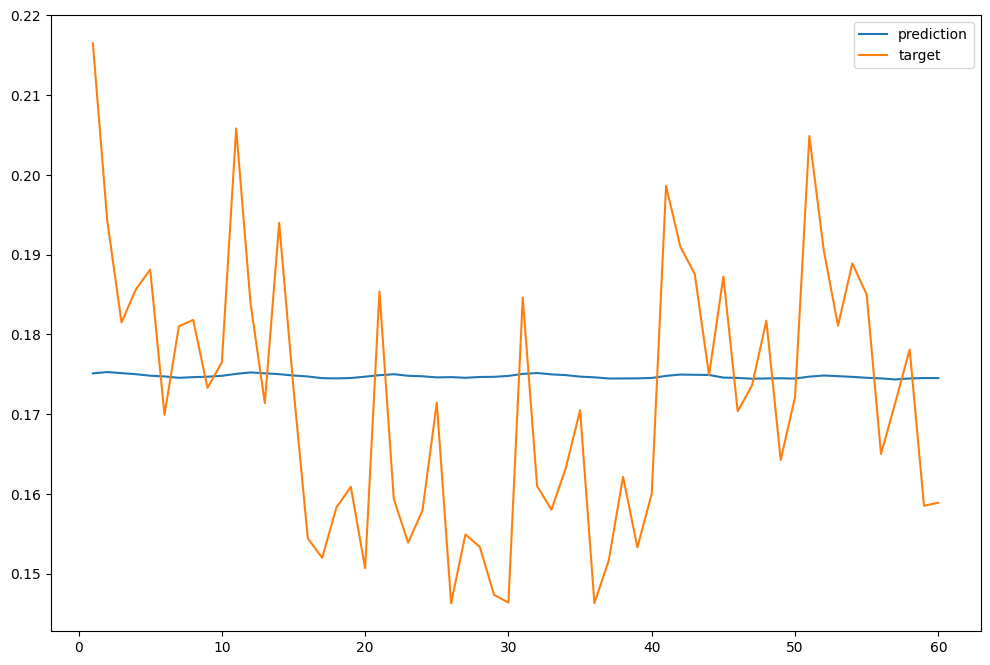

In [24]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [25]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 7.572423458099365 %


In [26]:
pred_list

[0.17511533200740814,
 0.1752864122390747,
 0.1751497983932495,
 0.17501750588417053,
 0.17482374608516693,
 0.17473725974559784,
 0.17456194758415222,
 0.17464570701122284,
 0.17470352351665497,
 0.17481224238872528,
 0.17505645751953125,
 0.17523843050003052,
 0.17512640357017517,
 0.17502069473266602,
 0.17484983801841736,
 0.1747312843799591,
 0.17451846599578857,
 0.17449259757995605,
 0.1745358407497406,
 0.17470517754554749,
 0.1748887598514557,
 0.17501336336135864,
 0.17481914162635803,
 0.17475591599941254,
 0.17461411654949188,
 0.17464768886566162,
 0.17456597089767456,
 0.17466440796852112,
 0.1746886968612671,
 0.17480045557022095,
 0.1750565469264984,
 0.17516309022903442,
 0.17499345541000366,
 0.1749020665884018,
 0.17471159994602203,
 0.17462164163589478,
 0.17447759211063385,
 0.17447921633720398,
 0.1744939684867859,
 0.17454621195793152,
 0.1748024970293045,
 0.17497216165065765,
 0.17493924498558044,
 0.17492039501667023,
 0.1745905876159668,
 0.174545556306839,
 

In [27]:
len(target)

10080

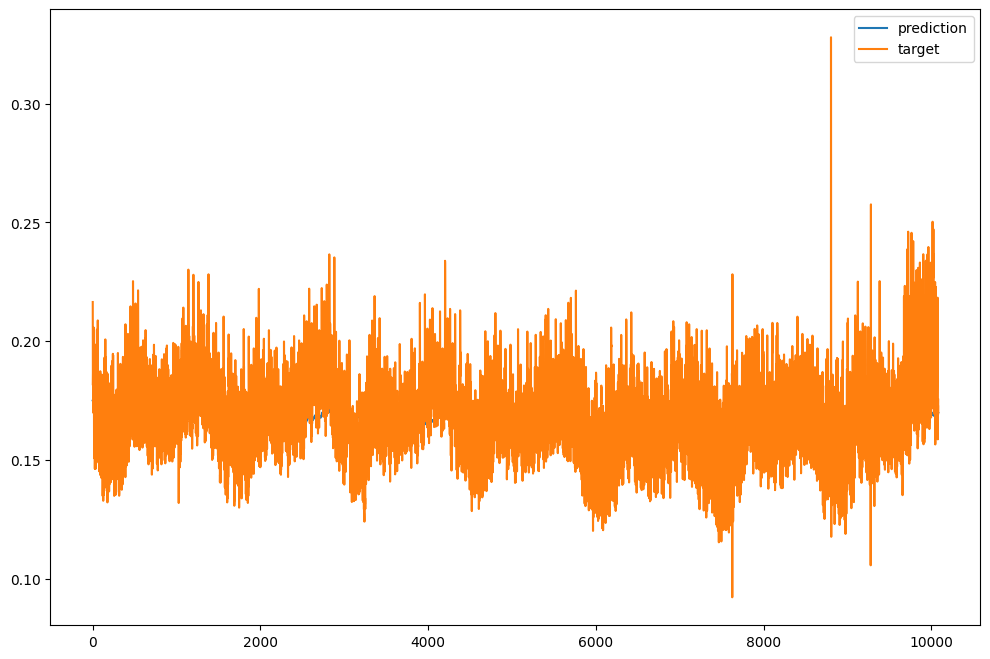

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

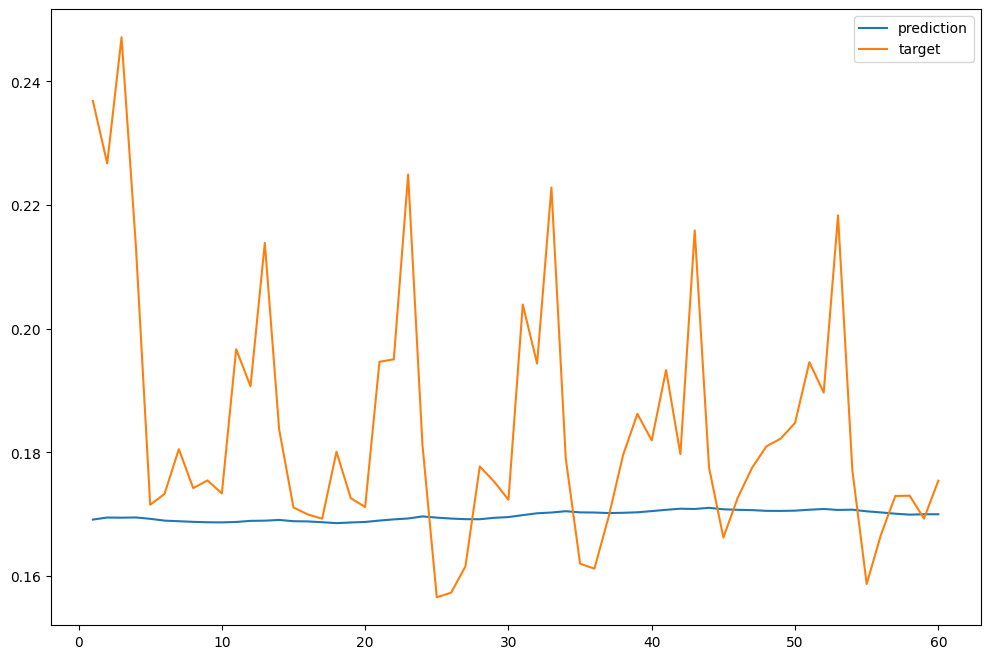

In [29]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [30]:
np.mean(time_list)

0.9627712443707481

1step과 비교했을때level을 맞추면서 sliding을 하게됨

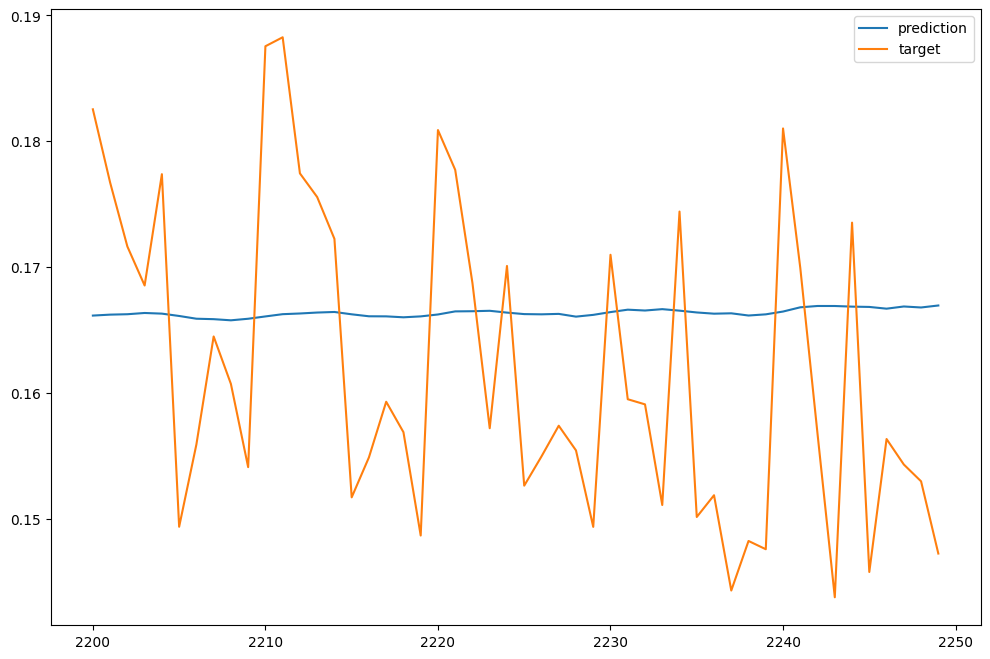

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()